In [10]:
import matplotlib.pyplot as plt
import glob
from PIL import Image, ImageDraw, ImageFont
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import defaultdict

from sklearn.model_selection import train_test_split
import albumentations as A
from glob import glob # Used to easily find file paths
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

## CNN model

In [11]:
df = pd.read_csv('data2.txt', sep='\s+', 
                 names=['REFNUM','BG','CLASS','SEVERITY','X','Y','RADIUS'], na_values=[''])
# Filter to your task (binary cancer detection)
df['CANCER'] = df['SEVERITY'].apply(lambda x: 1 if x in ['B', 'M'] else 0)
df = df[['REFNUM','X','Y','RADIUS','CANCER']]
df.head(5)

,REFNUM,X,Y,RADIUS,CANCER
0,REFNUM,X,Y,RADIUS,0
1,mdb001,535,425,197,1
2,mdb002,522,280,69,1
3,mdb003,NaN,NaN,NaN,0
4,mdb004,NaN,NaN,NaN,0


In [12]:
col_names = ['REFNUM', 'BG', 'CLASS', 'SEVERITY', 'X', 'Y', 'RADIUS']
df = pd.read_csv('data2.txt', sep="\s+", names=col_names, header=None)
df['CANCER'] = df['SEVERITY'].apply(lambda x: 1 if x in ['B', 'M'] else 0)
df.head(5)

,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS,CANCER
0,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS,0
1,mdb001,G,CIRC,B,535,425,197,1
2,mdb002,G,CIRC,B,522,280,69,1
3,mdb003,D,NORM,NaN,NaN,NaN,NaN,0
4,mdb004,D,NORM,NaN,NaN,NaN,NaN,0


In [16]:
def data_labeling(img_files, txt_path):
    full_data = []
    cordinates = []
    # count_cancer = 0
    # img_coordinate = defaultdict(list)
    
    for i, filename in enumerate(sorted(os.listdir(img_files))): # Opens the image file and go throuth all the image 
        if filename.endswith(".pgm"): # display only if the image is pgm
            image_path = os.path.join(img_files, filename) # Getting the Image path EX => all-mias\mdb001.pgm
            text = txt_file[i].strip() # spliting the data in the text file 
            pairing = {"Image": image_path, "Text": text} # putting both image and the text in the dictinory 
            full_data.append(pairing) # adding all the data to the list 

    for pairing in full_data:
        txt_value = pairing['Text'] # ceperating the image with the text
        img_value = pairing['Image']
        
        img = cv2.imread(img_value) # creating the array
        txt_parts = txt_value.split() # spleting text in to multiple in array so to filter the data which they have the cordinates
        
        # Converting the image to GRAY and then to RGB and prepare for drawing
        img_gray = cv2.imread(img_value, cv2.IMREAD_GRAYSCALE)  
        img_rgb = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2RGB)
       
        
        # Cheking if the text line contain the cordinate or not
        if len(txt_parts) == 7 and img is not None: 
            # Getting the cordinate for each image one by one 

            get_txt_data = txt_parts[4] + " " + txt_parts[5] + " " +txt_parts[6] # joining the X , Y , R
            x, y, r = map(int, get_txt_data.split())
            
            y_adj = 1024 - y
            cv2.circle(img_rgb, (x, y_adj), r, (0,255,0), 3)
            
            mask = np.zeros(img_rgb.shape[:2], dtype=np.uint8)
            cv2.circle(mask, (x, y_adj), r, 255, -1)
            roi = cv2.bitwise_and(img_rgb, img_rgb, mask=mask)

            # plt.imshow(img_rgb, cmap='gray')
            # plt.title("Example .pgm Image")
            # plt.axis('off')  # Hide axis ticks
            # plt.show()

# reading the Image file 
images_path = "all-mias"

# reading the txt file 
txt_path = "data2.txt"
with open(txt_path, "r") as file:
    txt_file = file.readlines()[1:]

data_labeling(images_path, txt_path)


In [3]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
TRAIN_DIR = 'dataset_for_training/train/'
VALIDATION_DIR = 'dataset_for_training/validation/'

# --- Step 1: Define the Albumentations Transform Pipeline ---
# This is where you define all your desired augmentations.
# These will be applied to the training images only.
# This is a powerful set of augmentations suitable for medical images.
train_transform = A.Compose([
    # Geometric transformations
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.7),
    A.ElasticTransform(p=0.3, alpha=50, sigma=5),
    A.Normalize(mean=[0.5], std=[0.5]),
    A.GridDistortion(p=0.5),
    
    # Brightness and contrast transformations
    A.RandomBrightnessContrast(
    brightness_limit=(-0.2, 0.3),  # Range
    contrast_limit=(-0.1, 0.1),    # Range
    p=1.0
    ),
    A.CLAHE(p=0.8), # This is excellent for enhancing contrast in medical images
    
    # Noise and blur
    A.GaussNoise(p=0.5),
    A.Blur(blur_limit=3, p=0.5),
    # A.ToTensorV2()
])

# For validation, we only need to resize and rescale. No random augmentation.
validation_transform = A.Compose([
    # Validation data should not be augmented randomly
])


# --- Step 2: Build the tf.data Pipeline (Replaces ImageDataGenerator) ---

# First, get all the file paths and their corresponding labels.
train_image_paths = glob(os.path.join(TRAIN_DIR, '*/*.png'))
validation_image_paths = glob(os.path.join(VALIDATION_DIR, '*/*.png'))

# Create labels from the folder names (0 for 'cancer', 1 for 'normal')
# Note: Keras's flow_from_directory sorts class names alphabetically.
# 'cancer' comes before 'normal', so Keras assigns it class 0.
train_labels = [0 if 'cancer' in path else 1 for path in train_image_paths]
validation_labels = [0 if 'cancer' in path else 1 for path in validation_image_paths]


def load_and_preprocess_image(image_path, label):
    """Loads, decodes, and resizes an image."""
    # Read the image file
    image = tf.io.read_file(image_path)
    # Decode to a tensor. We specify 3 channels as the model expects it.
    image = tf.io.decode_png(image, channels=3)
    # Resize the image to the target size
    image = tf.image.resize(image, [IMG_SIZE[0], IMG_SIZE[1]])
    # Rescale pixel values to [0, 1]
    image = image / 255.0
    return image, label

def apply_augmentations(image, label, transform):
    """A wrapper function to apply Albumentations transforms within TensorFlow."""
    def augment(img):
        aug_data = transform(image=img.numpy())
        return aug_data['image']

    # Use tf.py_function to run the python-based Albumentations library
    # The [image] and Tout=[tf.float32] define the input and output types.
    aug_image = tf.py_function(func=augment, inp=[image], Tout=tf.float32)
    # Make sure the output shape is set correctly
    aug_image.set_shape([IMG_SIZE[0], IMG_SIZE[1], 3])
    return aug_image, label


# Create the final training dataset object
train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_labels))
train_dataset = (
    train_dataset.shuffle(buffer_size=len(train_image_paths)) # Shuffle the data
    .map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE) # Load and resize
    .map(lambda x, y: apply_augmentations(x, y, train_transform), num_parallel_calls=tf.data.AUTOTUNE) # Apply augmentations
    .batch(BATCH_SIZE) # Create batches
    .prefetch(buffer_size=tf.data.AUTOTUNE) # Pre-load the next batch for performance
)

# Create the final validation dataset object (without augmentation)
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_image_paths, validation_labels))
validation_dataset = (
    validation_dataset
    .map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE) # Just load and resize
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# --- The rest of your code is now UNCHANGED ---

# --- 3. Build the Model with Transfer Learning (Unchanged) ---
base_model = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
base_model.trainable = False
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.5)(x)
predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

# --- 4. Compile the Model (Unchanged) ---
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# --- 5. Train the Model (Updated to use the new datasets) ---
print("Starting model training with Albumentations and tf.data pipeline...")
history = model.fit(
    train_dataset, # <-- Use the new training dataset
    epochs=20,
    validation_data=validation_dataset # <-- Use the new validation dataset
)

# --- 6. Save your trained model (Unchanged) ---
model.save('breast_cancer_classifier_v2_albumentations.h5')

C:\Users\aa23147\AppData\Roaming\Python\Python310\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Starting model training with Albumentations and tf.data pipeline...
Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.6034 - auc: 0.4883 - loss: 0.6803 - val_accuracy: 0.6406 - val_auc: 0.5000 - val_loss: 0.6640
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6195 - auc: 0.5697 - loss: 0.6650 - val_accuracy: 0.6406 - val_auc: 0.5000 - val_loss: 0.6554
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6470 - auc: 0.4944 - loss: 0.6505 - val_accuracy: 0.6406 - val_auc: 0.5000 - val_loss: 0.6529
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6527 - auc: 0.4970 - loss: 0.6472 - val_accuracy: 0.6406 - val_auc: 0.5000 - val_loss: 0.6533
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6594 - auc: 0.5119 - loss: 0.6417 - val_accuracy: 0.6406 - val_auc: 0.5000 - val_loss: 0.6535
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6220 - auc: 0.5511 - loss: 0.6669 - val_accuracy: 0.6406 - val_auc: 0.5000 - val_loss: 0.6

In [13]:

# --- Configuration ---
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
TRAIN_DIR = 'dataset_for_training/train/'
VALIDATION_DIR = 'dataset_for_training/validation/'

# --- Step 1: Create tf.data Datasets (Same as before) ---
# We use the same high-performance pipeline to load our images.
# This part is crucial for efficiently processing all images.

def load_and_preprocess_image(image_path, label):
    """Loads, decodes, and resizes an image."""
    image = tf.io.read_file(image_path)
    image = tf.io.decode_png(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE[0], IMG_SIZE[1]])
    image = image / 255.0  # Rescale to [0, 1]
    return image, label

# Get file paths and labels
train_image_paths = sorted(glob(os.path.join(TRAIN_DIR, '*/*.png')))
validation_image_paths = sorted(glob(os.path.join(VALIDATION_DIR, '*/*.png')))

# Keras assigns labels alphabetically: 'cancer' -> 0, 'normal' -> 1
train_labels = [0 if 'cancer' in path else 1 for path in train_image_paths]
validation_labels = [0 if 'cancer' in path else 1 for path in validation_image_paths]

# Create the dataset objects
train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_labels))
train_dataset = (
    train_dataset
    .map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((validation_image_paths, validation_labels))
validation_dataset = (
    validation_dataset
    .map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# --- Step 2: Build the Feature Extraction Model ---
# We load the CNN base but add a pooling layer to get a flat feature vector.
# This is NOT a classification model; its job is to turn an image into a list of numbers.
print("Building the feature extraction model...")
base_model = tf.keras.applications.EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(*IMG_SIZE, 3),
    pooling='avg' # Use 'avg' pooling to get a 1D feature vector per image
)
base_model.trainable = False # It's just a feature extractor, no training needed

# Our new feature_extractor_model is the base_model itself
feature_extractor_model = base_model


# --- Step 3: Extract Features from All Images ---
# We use the model's .predict() method to run all our images through it.
# This will give us the tabular data needed for the Random Forest.
print("Extracting features from the training set...")
X_train_features = feature_extractor_model.predict(train_dataset)

print("Extracting features from the validation set...")
X_val_features = feature_extractor_model.predict(validation_dataset)

# The labels are the same as before
y_train = np.array(train_labels)
y_val = np.array(validation_labels)

print(f"Shape of training features: {X_train_features.shape}")
print(f"Shape of validation features: {X_val_features.shape}")


# --- Step 4: Train the Random Forest Classifier ---
# Now we switch to scikit-learn to use its Random Forest implementation.
print("\nTraining the Random Forest model...")
# n_estimators: The number of trees in the forest.
# random_state: For reproducibility.
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# .fit() trains the model on our extracted features and labels
rf_model.fit(X_train_features, y_train)
print("Random Forest training complete.")


# --- Step 5: Evaluate the Random Forest Model ---
print("\nEvaluating the model on the validation set...")
# Use the trained model to make predictions on the validation features
predictions = rf_model.predict(X_val_features)

# Compare the predictions to the true labels
accuracy = accuracy_score(y_val, predictions)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

# Print a detailed report (precision, recall, f1-score)
print("\nClassification Report:")
# target_names uses the original folder names for clarity
print(classification_report(y_val, predictions, target_names=['cancer (0)', 'normal (1)']))


Building the feature extraction model...
Extracting features from the training set...
8/8 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step
Extracting features from the validation set...
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
Shape of training features: (256, 1280)
Shape of validation features: (64, 1280)

Training the Random Forest model...
Random Forest training complete.

Evaluating the model on the validation set...
Validation Accuracy: 100.00%

Classification Report:
              precision    recall  f1-score   support

  cancer (0)       1.00      1.00      1.00        23
  normal (1)       1.00      1.00      1.00        41

    accuracy                           1.00        64
   macro avg       1.00      1.00      1.00        64
weighted avg       1.00      1.00      1.00        64



In [20]:
# --- Step 6: Function to Predict a Single New Image ---
# This function encapsulates the entire prediction pipeline for a new image.

def predict_single_image(image_path, feature_extractor, rf_classifier):
    """
    Loads, preprocesses, and predicts the class for a single image file.

    Args:
        image_path (str): The file path to the new image.
        feature_extractor (tf.keras.Model): The trained CNN feature extractor.
        rf_classifier (RandomForestClassifier): The trained Random Forest model.

    Returns:
        tuple: A tuple containing the predicted label name and the confidence score.
    """
    print(f"\n--- Predicting for image: {os.path.basename(image_path)} ---")

    # 1. Load and preprocess the image using the same steps as training
    # The label is a placeholder since we don't know it yet.
    image_tensor, _ = load_and_preprocess_image(image_path, -1)

    # 2. Add a batch dimension. The model was trained on batches, so it
    # expects an input shape of (1, 224, 224, 3) instead of (224, 224, 3).
    image_batch = tf.expand_dims(image_tensor, axis=0)

    # 3. Extract features using the CNN model
    print("Extracting features from the image...")
    features = feature_extractor.predict(image_batch)

    # 4. Make a prediction using the trained Random Forest model
    print("Classifying features with Random Forest...")
    # .predict() gives the class (0 or 1)
    prediction_code = rf_classifier.predict(features)[0]
    # .predict_proba() gives the probability for each class
    prediction_proba = rf_classifier.predict_proba(features)[0]

    # 5. Interpret the results into human-readable format
    # The order 'cancer', 'normal' is based on how the labels were assigned alphabetically.
    class_names = ['cancer', 'normal']
    predicted_label = class_names[prediction_code]
    confidence = prediction_proba[prediction_code]

    return predicted_label, confidence

# --- Example of How to Use the Function ---
# This code assumes `feature_extractor_model` and `rf_model` are already
# trained and exist in memory from the script in the Canvas.

# Let's pick an example image from your validation set to test.
# Make sure this file exists. We'll use the 10th image as an example.
example_image_path = validation_image_paths[11]
print(validation_image_paths)

# Call the prediction function
predicted_class, confidence_score = predict_single_image(
    image_path=example_image_path,
    feature_extractor=feature_extractor_model,
    rf_classifier=rf_model
)

# Print the final result in a clean format
print("\n============== PREDICTION RESULT ==============")
print(f"The model predicts this image is: '{predicted_class}'")
print(f"Confidence score: {confidence_score * 100:.2f}%")
print("=============================================")

# As a check, let's see what the real label was
true_label_code = validation_labels[9]
true_label_name = 'cancer' if true_label_code == 0 else 'normal'
print(f"(For verification, the true label is: '{true_label_name}')")

['dataset_for_training/validation\\cancer\\mdb021_roi.png', 'dataset_for_training/validation\\cancer\\mdb032_roi.png', 'dataset_for_training/validation\\cancer\\mdb058_roi.png', 'dataset_for_training/validation\\cancer\\mdb081_roi.png', 'dataset_for_training/validation\\cancer\\mdb102_roi.png', 'dataset_for_training/validation\\cancer\\mdb115_roi.png', 'dataset_for_training/validation\\cancer\\mdb126_roi.png', 'dataset_for_training/validation\\cancer\\mdb152_roi.png', 'dataset_for_training/validation\\cancer\\mdb155_roi.png', 'dataset_for_training/validation\\cancer\\mdb163_roi.png', 'dataset_for_training/validation\\cancer\\mdb184_roi.png', 'dataset_for_training/validation\\cancer\\mdb186_roi.png', 'dataset_for_training/validation\\cancer\\mdb188_roi.png', 'dataset_for_training/validation\\cancer\\mdb193_roi.png', 'dataset_for_training/validation\\cancer\\mdb198_roi.png', 'dataset_for_training/validation\\cancer\\mdb207_roi.png', 'dataset_for_training/validation\\cancer\\mdb223_roi.pn


Displaying a sample validation image before evaluation...


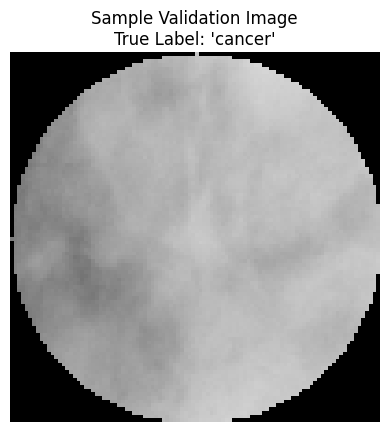


Evaluating the model on the validation set...


In [21]:
# --- (This code goes right before Step 5) ---

print("\nDisplaying a sample validation image before evaluation...")

# Choose an example image to display (e.g., the 10th image)
example_image_path = validation_image_paths[9]
example_true_label_code = validation_labels[9]
example_true_label_name = 'cancer' if example_true_label_code == 0 else 'normal'

# Read the image file using OpenCV
# We read it directly from the file for a clean, original view
image_to_plot = cv2.imread(example_image_path)
# Convert from BGR (OpenCV's default) to RGB for correct colors in matplotlib
image_to_plot = cv2.cvtColor(image_to_plot, cv2.COLOR_BGR2RGB)

# Plot the image
plt.imshow(image_to_plot)
plt.title(f"Sample Validation Image\nTrue Label: '{example_true_label_name}'")
plt.axis('off')  # Hide the axes for a cleaner look
plt.show()

# --- Step 5: Evaluate the Random Forest Model ---
# (Your existing code continues here...)
print("\nEvaluating the model on the validation set...")

In [16]:
# img = [].
# for file in img_files:
#     image = Image.open(file)
#     img.append(image)
# # images = [Image.open(file) for file in img_files]

# columns = 5
# rows = len(img) // columns + int(len(img) % columns !=0)

# fig, axes = plt.subplots(rows, columns, figsize=(15,15))
# axes = axes.flatten()

# for idx, image in enumerate(img):
#     axes[idx].imshow(image, cmap='gray')
#     axes[idx].axis('off')
#     axes[idx].set_title(f"Image {idx+1}")

# for ax in axes[len(img):]:
#     ax.axis('off')



# print(f"found {len(img_files)} .pgm images")
# plt.tight_layout()
# plt.show()
#####################################################################
# cols = 5
# rows = len(images) // cols + int(len(images) % cols != 0)

# # Create subplots
# # fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
# fig, axes = plt.subplots(rows, cols, figsize=(15, 15))

# axes = axes.flatten()  # Flatten in case of 2D array of axes

# # Loop through images and plot each one
# for idx, img in enumerate(images):
#     axes[idx].imshow(img, cmap='gray')
#     axes[idx].axis('off')
#     axes[idx].set_title(f"Image {idx+1}")

# # Turn off any unused subplots
# for ax in axes[len(images):]:
#     ax.axis('off')

# plt.tight_layout()
# plt.show()

In [ ]:
# # reading the Image file 
# img_files = glob.glob("all-mias")
# # img_files = "all-mias"
# print(f"found {len(img_files)} .pmg images")

# # reading the txt file 
# txt_path = "info.txt"
# with open(txt_path, "r") as file:
#     txt_file = file.readlines()

# first_img = Image.open(img_files[11])
# plt.imshow(first_img, cmap='gray')
# plt.title("Example .pgm Image")
# plt.axis('off')  # Hide axis ticks
# plt.show()

In [5]:
pip install imblearn 

Defaulting to user installation because normal site-packages is not writeable

   ------------- -------------------------- 1/3 [imbalanced-learn]
   ------------- -------------------------- 1/3 [imbalanced-learn]
   ---------------------------------------- 3/3 [imblearn]

Note: you may need to restart the kernel to use updated packages.


In [10]:
import numpy as np
import pandas as pd
import cv2
import os
from skimage import feature
from skimage.feature import graycomatrix, graycoprops
from sklearn.model_selection import train_test_split, GridSearchCV, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE

# --- 1. Data Loading with ROI Extraction ---
col_names = ['REFNUM', 'BG', 'CLASS', 'SEVERITY', 'X', 'Y', 'RADIUS']
df = pd.read_csv('data2.txt', sep=r"\s+", names=col_names, header=None)
df['CANCER'] = df['SEVERITY'].apply(lambda x: 1 if x in ['B', 'M'] else 0)

images_path = "all-mias"
all_images = []
all_labels = []
all_groups = []

for filename in sorted(os.listdir(images_path)):
    if filename.lower().endswith('.pgm'):
        ref_num = os.path.splitext(filename)[0]
        record = df[df['REFNUM'] == ref_num]
        if not record.empty:
            full_path = os.path.join(images_path, filename)
            img = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
            img = clahe.apply(img)
            
            label = record['CANCER'].iloc[0]
            x, y, r = record[['X', 'Y', 'RADIUS']].iloc[0]
            
            if label == 1 and pd.notna(x) and pd.notna(y) and pd.notna(r):
                # Crop ROI for Abnormal
                x, y, r = int(x), int(y), int(r)
                roi = img[max(0, y-r):min(1024, y+r), max(0, x-r):min(1024, x+r)]
            else:
                # Use full image for Normal or missing coordinates
                roi = img
                
            all_images.append(roi)
            all_labels.append(label)
            all_groups.append(ref_num[:-1])  # Group by patient (e.g., 'mdb001' -> 'mdb00')

# --- 2. Feature Extraction (LBP + GLCM) ---
def extract_features(img, P=8, R=3):
    # LBP
    lbp = feature.local_binary_pattern(img, P, R, method='uniform')
    # num_bins = int(lbp.max() + 1)
    num_bins = P + 2
    hist, _ = np.histogram(lbp, bins=num_bins, range=(0, num_bins))
    
    # GLCM
    glcm = graycomatrix(img, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256)
    glcm_features = [
        graycoprops(glcm, 'contrast').mean(),
        graycoprops(glcm, 'dissimilarity').mean(),
        graycoprops(glcm, 'homogeneity').mean(),
        graycoprops(glcm, 'energy').mean(),
        graycoprops(glcm, 'correlation').mean()
    ]
    
    return np.concatenate([hist, glcm_features])

X = np.array([extract_features(img) for img in all_images])
y = np.array(all_labels)
groups = np.array(all_groups)

# --- 3. Data Splitting and Scaling ---
gss = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups))
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# --- 4. Handle Imbalance ---
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# --- 5. Model Training ---
# Random Forest
rf = RandomForestClassifier(n_estimators=150, class_weight='balanced', random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest Results:")
print(classification_report(y_test, y_pred_rf, target_names=['Normal', 'Cancer']))
print("AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]))

# SVM
svm = SVC(probability=True, class_weight='balanced', random_state=42)
param_grid = {'C': [0.1, 1, 10], 'gamma': ['scale', 0.1], 'kernel': ['rbf']}
grid_svm = GridSearchCV(svm, param_grid, cv=5, scoring='roc_auc')
grid_svm.fit(X_train, y_train)
y_pred_svm = grid_svm.predict(X_test)
print("SVM Results:")
print(classification_report(y_test, y_pred_svm, target_names=['Normal', 'Cancer']))
print("AUC:", roc_auc_score(y_test, grid_svm.predict_proba(X_test)[:, 1]))

Random Forest Results:
              precision    recall  f1-score   support

      Normal       0.98      1.00      0.99        53
      Cancer       1.00      0.98      0.99        46

    accuracy                           0.99        99
   macro avg       0.99      0.99      0.99        99
weighted avg       0.99      0.99      0.99        99

AUC: 0.9837981952420016
SVM Results:
              precision    recall  f1-score   support

      Normal       0.98      1.00      0.99        53
      Cancer       1.00      0.98      0.99        46

    accuracy                           0.99        99
   macro avg       0.99      0.99      0.99        99
weighted avg       0.99      0.99      0.99        99

AUC: 0.9909762100082035


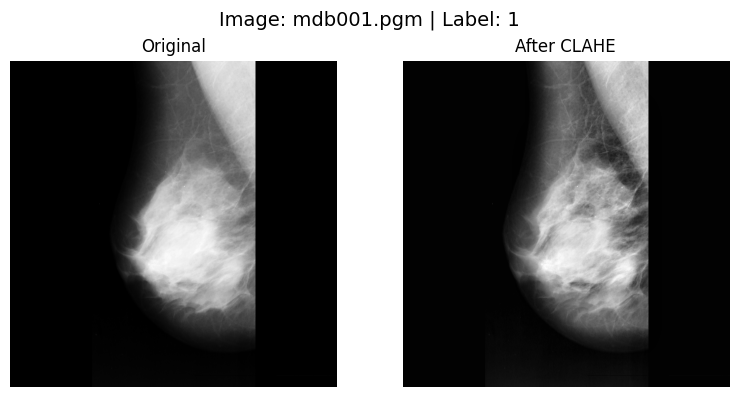

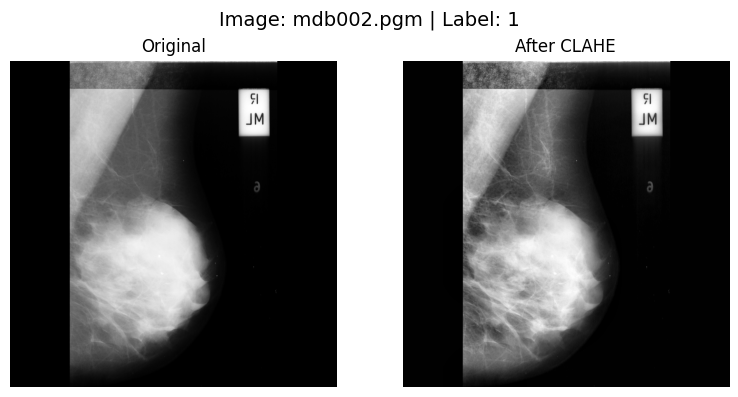

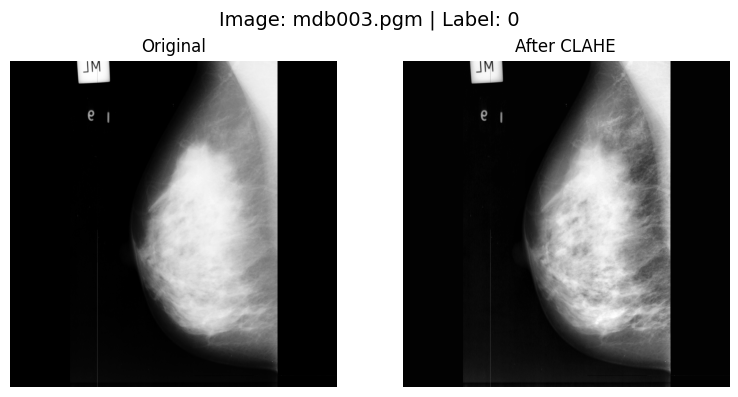

Data has been loaded successfully
Image list: 324
Labels list: 324


In [1]:
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt

# Load the data
col_names = ['REFNUM', 'BG', 'CLASS', 'SEVERITY', 'X', 'Y', 'RADIUS']
df = pd.read_csv('data2.txt', sep="\s+", names=col_names, header=None)
df['CANCER'] = df['SEVERITY'].apply(lambda x: 1 if x in ['B', 'M'] else 0)

images_path = "all-mias"

all_images = []
all_labels = []
all_groups = []

count = 0  # to display only a few images

for filename in sorted(os.listdir(images_path)):
    if filename.lower().endswith('.pgm'):
        ref_num = os.path.splitext(filename)[0]
        record = df[df['REFNUM'] == ref_num]

        if not record.empty:
            full_path = os.path.join(images_path, filename)
            img_array = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)

            # Apply CLAHE
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
            img_eq = clahe.apply(img_array)

            # Store processed images and labels
            labels = record['CANCER'].iloc[0]
            all_images.append(img_eq)
            all_labels.append(labels)
            all_groups.append(ref_num[:-1])

            # Show original vs CLAHE for the first 3 images
            if count < 3:
                plt.figure(figsize=(8, 4))
                plt.subplot(1, 2, 1)
                plt.imshow(img_array, cmap='gray')
                plt.title("Original")
                plt.axis('off')

                plt.subplot(1, 2, 2)
                plt.imshow(img_eq, cmap='gray')
                plt.title("After CLAHE")
                plt.axis('off')

                plt.suptitle(f"Image: {filename} | Label: {labels}", fontsize=14)
                plt.tight_layout()
                plt.show()
                count += 1

print("Data has been loaded successfully")
print(f"Image list: {len(all_images)}")
print(f"Labels list: {len(all_labels)}")


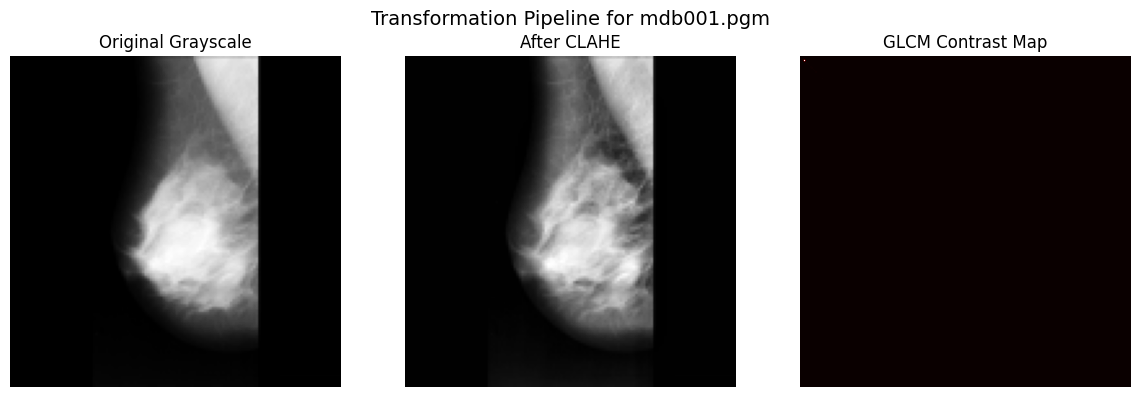

In [2]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from skimage.feature import graycomatrix, graycoprops

# Load metadata
col_names = ['REFNUM', 'BG', 'CLASS', 'SEVERITY', 'X', 'Y', 'RADIUS']
df = pd.read_csv('data2.txt', sep="\s+", names=col_names, header=None)
df['CANCER'] = df['SEVERITY'].apply(lambda x: 1 if x in ['B', 'M'] else 0)

images_path = "all-mias"

def extract_glcm_features_matrix(patch, distances=[1], angles=[0], levels=256):
    """Return the raw GLCM matrix for visualizing (contrast, homogeneity, etc.)"""
    patch = (patch * (levels - 1)).astype(np.uint8) if patch.max() <= 1 else patch.astype(np.uint8)
    glcm = graycomatrix(patch, distances=distances, angles=angles, levels=levels, symmetric=True, normed=True)
    return glcm

# Process only the first valid image
for filename in sorted(os.listdir(images_path)):
    if filename.lower().endswith('.pgm'):
        ref_num = os.path.splitext(filename)[0]
        record = df[df['REFNUM'] == ref_num]

        if not record.empty:
            full_path = os.path.join(images_path, filename)
            img_array = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)

            # CLAHE step
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            img_eq = clahe.apply(img_array)

            # Crop or resize image to smaller fixed size for visualization
            img_resized = cv2.resize(img_array, (128, 128), interpolation=cv2.INTER_AREA)
            img_eq_resized = cv2.resize(img_eq, (128, 128), interpolation=cv2.INTER_AREA)

            # Compute GLCM and extract contrast for 1 distance & 0° angle
            glcm = extract_glcm_features_matrix(img_eq_resized, distances=[1], angles=[0])
            contrast_map = glcm[:, :, 0, 0]  # distance=1, angle=0

            # Normalize contrast map for display
            contrast_map = (contrast_map - contrast_map.min()) / (contrast_map.max() - contrast_map.min() + 1e-10)

            # Display all three images
            plt.figure(figsize=(12, 4))

            plt.subplot(1, 3, 1)
            plt.imshow(img_resized, cmap='gray')
            plt.title("Original Grayscale")
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.imshow(img_eq_resized, cmap='gray')
            plt.title("After CLAHE")
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.imshow(contrast_map, cmap='hot')
            plt.title("GLCM Contrast Map")
            plt.axis('off')

            plt.suptitle(f"Transformation Pipeline for {filename}", fontsize=14)
            plt.tight_layout()
            plt.show()
            break  # only process one image
